# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Howard Wang (b08902047@ntu.edu.tw)

If there are any questions, please contact mlta-2023-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

>

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains.


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [1]:
# Download dataset
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files
# !unzip real_or_drawing.zip

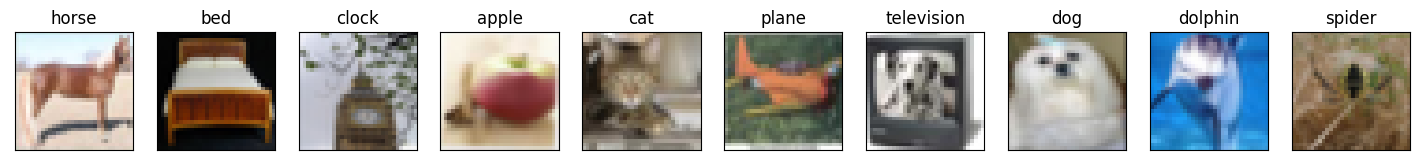

In [2]:
import matplotlib.pyplot as plt


def no_axis_show(img, title="", cmap=None):
    # imshow, and set the interpolation mode to be "nearest"。
    fig = plt.imshow(img, interpolation="nearest", cmap=cmap)
    # do not show the axes in the images.
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)


titles = ["horse", "bed", "clock", "apple", "cat", "plane", "television", "dog", "dolphin", "spider"]
plt.figure(figsize=(18, 18))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    fig = no_axis_show(plt.imread(f"real_or_drawing/train_data/{i}/{500*i}.bmp"), title=titles[i])


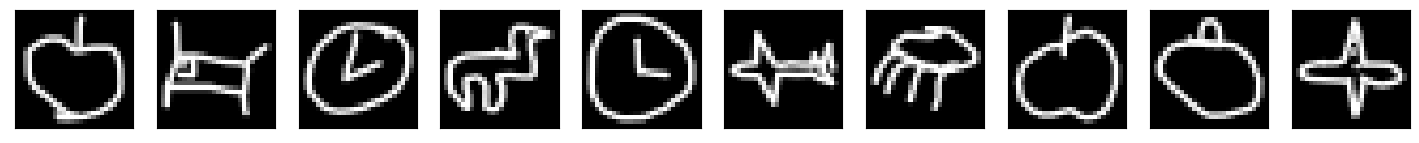

In [3]:
plt.figure(figsize=(18, 18))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    fig = no_axis_show(plt.imread(f"real_or_drawing/test_data/0/" + str(i).rjust(5, "0") + ".bmp"))


# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

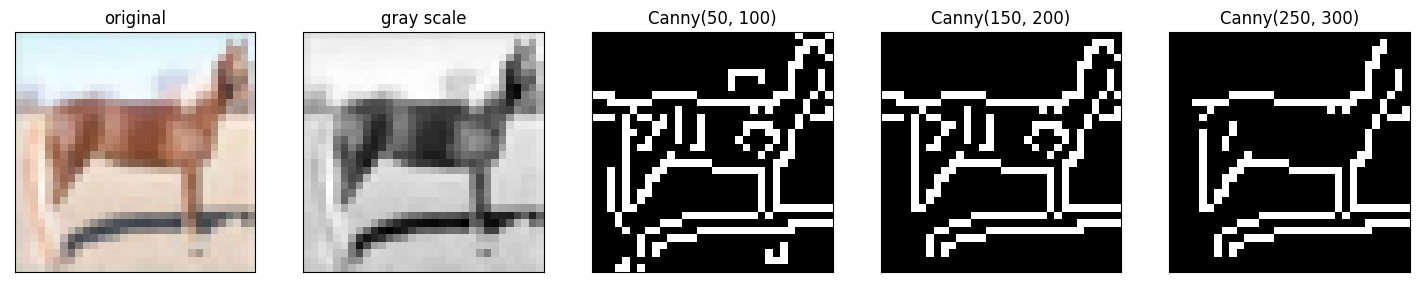

In [4]:
import cv2
import matplotlib.pyplot as plt

titles = ["horse", "bed", "clock", "apple", "cat", "plane", "television", "dog", "dolphin", "spider"]
plt.figure(figsize=(18, 18))

original_img = plt.imread(f"real_or_drawing/train_data/0/0.bmp")
plt.subplot(1, 5, 1)
no_axis_show(original_img, title="original")

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title="gray scale", cmap="gray")

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title="gray scale", cmap="gray")

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title="Canny(50, 100)", cmap="gray")

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title="Canny(150, 200)", cmap="gray")

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title="Canny(250, 300)", cmap="gray")


# Data Process


The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, TimeRemainingColumn, track
import time


source_transform = transforms.Compose(
    [
        # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
        transforms.Grayscale(),
        # cv2 do not support skimage.Image, so we transform it to np.array,
        # and then adopt cv2.Canny algorithm.
        transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
        # Transform np.array back to the skimage.Image.
        transforms.ToPILImage(),
        # 50% Horizontal Flip. (For Augmentation)
        transforms.RandomHorizontalFlip(),
        # Rotate +- 15 degrees. (For Augmentation), and filled with zero
        # if there's empty pixel after rotation.
        transforms.RandomRotation(15, fill=(0,)),
        # Transform to tensor for model inputs.
        transforms.ToTensor(),
    ]
)
target_transform = transforms.Compose(
    [
        # Turn RGB to grayscale.
        transforms.Grayscale(),
        # Resize: size of source data is 32x32, thus we need to
        #  enlarge the size of target data from 28x28 to 32x32。
        transforms.Resize((32, 32)),
        # 50% Horizontal Flip. (For Augmentation)
        transforms.RandomHorizontalFlip(),
        # Rotate +- 15 degrees. (For Augmentation), and filled with zero
        # if there's empty pixel after rotation.
        transforms.RandomRotation(15, fill=(0,)),
        # Transform to tensor for model inputs.
        transforms.ToTensor(),
    ]
)

source_dataset = ImageFolder("real_or_drawing/train_data", transform=source_transform)
target_dataset = ImageFolder("real_or_drawing/test_data", transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)


# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        x = self.conv(x).squeeze()
        return x


class LabelPredictor(nn.Module):
    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c


class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y


# Pre-processing

Here we use Adam as our optimizor.

In [7]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())


# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [8]:
def train_epoch(source_dataloader, target_dataloader, progress, lamb):
    """
    Args:
      source_dataloader: source data的dataloader
      target_dataloader: target data的dataloader
      lamb: control the balance of domain adaptatoin and classification.
    """

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    batch_tqdm = progress.add_task(description=f"batch_progress", total=len(source_dataloader))

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()

        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[: source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[: source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss += loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        progress.advance(batch_tqdm, advance=1)

    progress.remove_task(batch_tqdm)
    return running_D_loss / (i + 1), running_F_loss / (i + 1), total_hit / total_num


num_epochs = 1000

with Progress(
    TextColumn("[progress.description]{task.description}"), BarColumn(), TextColumn("[progress.percentage]{task.percentage:>3.0f}%"), TimeRemainingColumn(), TimeElapsedColumn()
) as progress:
    epoch_tqdm = progress.add_task(description="epoch progress", total=num_epochs)
    for epoch in range(num_epochs):
        lamb = (2 / (1 + np.exp(-10 * (epoch) / num_epochs))) - 1
        train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, progress, lamb=lamb)

        progress.advance(epoch_tqdm, advance=1)
        if epoch == 50:
            torch.save(feature_extractor.state_dict(), f"weights/extractor_model_early.bin")
            torch.save(label_predictor.state_dict(), f"weights/predictor_model_early.bin")
        elif epoch == 500:
            torch.save(feature_extractor.state_dict(), f"weights/extractor_model_mid.bin")
            torch.save(label_predictor.state_dict(), f"weights/predictor_model_mid.bin")

        torch.save(feature_extractor.state_dict(), f"weights/extractor_model.bin")
        torch.save(label_predictor.state_dict(), f"weights/predictor_model.bin")
        if epoch % 5 == 0:
            print("epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}".format(epoch, train_D_loss, train_F_loss, train_acc))


Output()

epoch   0: train D loss: 0.1080, train F loss: 1.9797, acc 0.2598

epoch   5: train D loss: 0.2905, train F loss: 1.3015, acc 0.5494

epoch  10: train D loss: 0.3673, train F loss: 1.0872, acc 0.6214

epoch  15: train D loss: 0.3984, train F loss: 0.9302, acc 0.6556

epoch  20: train D loss: 0.4475, train F loss: 0.7337, acc 0.7336

epoch  25: train D loss: 0.4614, train F loss: 0.5889, acc 0.7740

epoch  30: train D loss: 0.4753, train F loss: 0.4254, acc 0.8310

epoch  35: train D loss: 0.4766, train F loss: 0.3203, acc 0.8632

epoch  40: train D loss: 0.5025, train F loss: 0.2085, acc 0.9006

epoch  45: train D loss: 0.5125, train F loss: 0.1655, acc 0.9108

epoch  60: train D loss: 0.5400, train F loss: 0.0427, acc 0.9414

epoch  65: train D loss: 0.5686, train F loss: -0.0156, acc 0.9456

epoch  70: train D loss: 0.5629, train F loss: -0.0421, acc 0.9550

epoch  75: train D loss: 0.5921, train F loss: -0.0604, acc 0.9508

epoch  80: train D loss: 0.5847, train F loss: -0.0805, acc 0.9550

epoch  85: train D loss: 0.6017, train F loss: -0.1123, acc 0.9564

epoch  90: train D loss: 0.6036, train F loss: -0.1357, acc 0.9640

epoch  95: train D loss: 0.5999, train F loss: -0.1430, acc 0.9620

epoch 100: train D loss: 0.6054, train F loss: -0.1635, acc 0.9646

epoch 105: train D loss: 0.6087, train F loss: -0.1685, acc 0.9634

epoch 110: train D loss: 0.6171, train F loss: -0.2064, acc 0.9692

epoch 115: train D loss: 0.6331, train F loss: -0.2397, acc 0.9710

epoch 120: train D loss: 0.6243, train F loss: -0.2407, acc 0.9740

epoch 125: train D loss: 0.6228, train F loss: -0.2377, acc 0.9658

epoch 130: train D loss: 0.6244, train F loss: -0.2613, acc 0.9726

epoch 135: train D loss: 0.6295, train F loss: -0.2796, acc 0.9694

epoch 140: train D loss: 0.6302, train F loss: -0.2871, acc 0.9756

epoch 145: train D loss: 0.6413, train F loss: -0.3128, acc 0.9768

epoch 150: train D loss: 0.6322, train F loss: -0.3174, acc 0.9758

epoch 155: train D loss: 0.6331, train F loss: -0.3129, acc 0.9712

epoch 160: train D loss: 0.6447, train F loss: -0.3421, acc 0.9750

epoch 165: train D loss: 0.6428, train F loss: -0.3485, acc 0.9752

epoch 170: train D loss: 0.6450, train F loss: -0.3556, acc 0.9730

epoch 175: train D loss: 0.6439, train F loss: -0.3703, acc 0.9784

epoch 180: train D loss: 0.6461, train F loss: -0.3801, acc 0.9772

epoch 185: train D loss: 0.6464, train F loss: -0.3994, acc 0.9794

epoch 190: train D loss: 0.6490, train F loss: -0.4132, acc 0.9808

epoch 195: train D loss: 0.6462, train F loss: -0.4145, acc 0.9796

epoch 200: train D loss: 0.6491, train F loss: -0.4106, acc 0.9734

epoch 205: train D loss: 0.6464, train F loss: -0.4126, acc 0.9742

epoch 210: train D loss: 0.6607, train F loss: -0.4333, acc 0.9768

epoch 215: train D loss: 0.6572, train F loss: -0.4380, acc 0.9746

epoch 220: train D loss: 0.6533, train F loss: -0.4410, acc 0.9778

epoch 225: train D loss: 0.6444, train F loss: -0.4418, acc 0.9784

epoch 230: train D loss: 0.6575, train F loss: -0.4716, acc 0.9806

epoch 235: train D loss: 0.6601, train F loss: -0.4681, acc 0.9766

epoch 240: train D loss: 0.6569, train F loss: -0.4719, acc 0.9796

epoch 245: train D loss: 0.6577, train F loss: -0.4806, acc 0.9806

epoch 250: train D loss: 0.6549, train F loss: -0.4743, acc 0.9768

epoch 255: train D loss: 0.6565, train F loss: -0.4933, acc 0.9824

epoch 260: train D loss: 0.6582, train F loss: -0.4937, acc 0.9792

epoch 265: train D loss: 0.6579, train F loss: -0.5000, acc 0.9812

epoch 270: train D loss: 0.6554, train F loss: -0.4961, acc 0.9794

epoch 275: train D loss: 0.6620, train F loss: -0.5158, acc 0.9814

epoch 280: train D loss: 0.6616, train F loss: -0.5311, acc 0.9848

epoch 285: train D loss: 0.6597, train F loss: -0.5182, acc 0.9814

epoch 290: train D loss: 0.6615, train F loss: -0.5140, acc 0.9818

epoch 300: train D loss: 0.6640, train F loss: -0.5320, acc 0.9828

epoch 305: train D loss: 0.6584, train F loss: -0.5398, acc 0.9822

epoch 310: train D loss: 0.6651, train F loss: -0.5325, acc 0.9802

epoch 315: train D loss: 0.6639, train F loss: -0.5505, acc 0.9838

epoch 320: train D loss: 0.6632, train F loss: -0.5347, acc 0.9792

epoch 330: train D loss: 0.6652, train F loss: -0.5641, acc 0.9850

epoch 335: train D loss: 0.6611, train F loss: -0.5508, acc 0.9828

epoch 340: train D loss: 0.6636, train F loss: -0.5588, acc 0.9834

epoch 345: train D loss: 0.6636, train F loss: -0.5691, acc 0.9850

epoch 350: train D loss: 0.6667, train F loss: -0.5669, acc 0.9814

epoch 360: train D loss: 0.6675, train F loss: -0.5649, acc 0.9810

epoch 365: train D loss: 0.6569, train F loss: -0.5602, acc 0.9848

epoch 370: train D loss: 0.6631, train F loss: -0.5817, acc 0.9874

epoch 375: train D loss: 0.6613, train F loss: -0.5720, acc 0.9866

epoch 380: train D loss: 0.6662, train F loss: -0.5838, acc 0.9862

epoch 385: train D loss: 0.6613, train F loss: -0.5674, acc 0.9834

epoch 390: train D loss: 0.6646, train F loss: -0.5806, acc 0.9866

epoch 395: train D loss: 0.6626, train F loss: -0.5701, acc 0.9826

epoch 400: train D loss: 0.6651, train F loss: -0.5819, acc 0.9832

epoch 405: train D loss: 0.6683, train F loss: -0.5878, acc 0.9836

epoch 410: train D loss: 0.6647, train F loss: -0.5867, acc 0.9856

epoch 415: train D loss: 0.6667, train F loss: -0.5880, acc 0.9856

epoch 420: train D loss: 0.6629, train F loss: -0.5841, acc 0.9848

epoch 425: train D loss: 0.6687, train F loss: -0.6022, acc 0.9868

epoch 430: train D loss: 0.6675, train F loss: -0.5853, acc 0.9838

epoch 435: train D loss: 0.6714, train F loss: -0.6010, acc 0.9864

epoch 440: train D loss: 0.6679, train F loss: -0.6028, acc 0.9856

epoch 445: train D loss: 0.6678, train F loss: -0.6006, acc 0.9832

epoch 450: train D loss: 0.6653, train F loss: -0.5940, acc 0.9850

epoch 455: train D loss: 0.6689, train F loss: -0.6046, acc 0.9874

epoch 460: train D loss: 0.6620, train F loss: -0.5869, acc 0.9822

epoch 465: train D loss: 0.6663, train F loss: -0.6027, acc 0.9870

epoch 470: train D loss: 0.6700, train F loss: -0.6141, acc 0.9886

epoch 475: train D loss: 0.6667, train F loss: -0.6053, acc 0.9856

epoch 480: train D loss: 0.6694, train F loss: -0.6048, acc 0.9854

epoch 490: train D loss: 0.6691, train F loss: -0.6007, acc 0.9868

epoch 495: train D loss: 0.6656, train F loss: -0.6027, acc 0.9864

epoch 500: train D loss: 0.6673, train F loss: -0.5947, acc 0.9832

epoch 505: train D loss: 0.6636, train F loss: -0.6037, acc 0.9884

epoch 510: train D loss: 0.6674, train F loss: -0.5918, acc 0.9846

epoch 515: train D loss: 0.6638, train F loss: -0.5840, acc 0.9836

epoch 520: train D loss: 0.6696, train F loss: -0.6109, acc 0.9838

epoch 525: train D loss: 0.6699, train F loss: -0.6118, acc 0.9864

epoch 530: train D loss: 0.6668, train F loss: -0.6098, acc 0.9858

epoch 535: train D loss: 0.6716, train F loss: -0.6218, acc 0.9892

epoch 540: train D loss: 0.6707, train F loss: -0.6142, acc 0.9874

epoch 545: train D loss: 0.6722, train F loss: -0.6161, acc 0.9860

epoch 555: train D loss: 0.6657, train F loss: -0.6043, acc 0.9856

epoch 560: train D loss: 0.6678, train F loss: -0.6106, acc 0.9860

epoch 565: train D loss: 0.6692, train F loss: -0.6169, acc 0.9884

epoch 570: train D loss: 0.6723, train F loss: -0.6261, acc 0.9880

epoch 575: train D loss: 0.6729, train F loss: -0.6159, acc 0.9868

epoch 580: train D loss: 0.6738, train F loss: -0.6185, acc 0.9868

epoch 585: train D loss: 0.6762, train F loss: -0.6086, acc 0.9808

epoch 590: train D loss: 0.6655, train F loss: -0.6120, acc 0.9872

epoch 595: train D loss: 0.6700, train F loss: -0.6120, acc 0.9860

epoch 600: train D loss: 0.6666, train F loss: -0.6144, acc 0.9880

epoch 605: train D loss: 0.6676, train F loss: -0.6188, acc 0.9888

epoch 610: train D loss: 0.6711, train F loss: -0.6190, acc 0.9860

epoch 615: train D loss: 0.6752, train F loss: -0.6273, acc 0.9896

epoch 620: train D loss: 0.6735, train F loss: -0.6241, acc 0.9886

epoch 625: train D loss: 0.6727, train F loss: -0.6234, acc 0.9874

epoch 630: train D loss: 0.6645, train F loss: -0.6103, acc 0.9860

epoch 635: train D loss: 0.6708, train F loss: -0.6162, acc 0.9868

epoch 640: train D loss: 0.6677, train F loss: -0.6240, acc 0.9898

epoch 645: train D loss: 0.6667, train F loss: -0.6240, acc 0.9904

epoch 650: train D loss: 0.6652, train F loss: -0.6066, acc 0.9846

epoch 655: train D loss: 0.6715, train F loss: -0.6261, acc 0.9892

epoch 660: train D loss: 0.6698, train F loss: -0.6246, acc 0.9874

epoch 665: train D loss: 0.6684, train F loss: -0.6246, acc 0.9888

epoch 670: train D loss: 0.6667, train F loss: -0.6166, acc 0.9872

epoch 675: train D loss: 0.6706, train F loss: -0.6186, acc 0.9878

epoch 680: train D loss: 0.6730, train F loss: -0.6294, acc 0.9900

epoch 690: train D loss: 0.6613, train F loss: -0.6146, acc 0.9900

epoch 695: train D loss: 0.6701, train F loss: -0.6259, acc 0.9890

epoch 700: train D loss: 0.6705, train F loss: -0.6215, acc 0.9882

epoch 705: train D loss: 0.6712, train F loss: -0.6336, acc 0.9902

epoch 710: train D loss: 0.6689, train F loss: -0.6342, acc 0.9914

epoch 715: train D loss: 0.6740, train F loss: -0.6255, acc 0.9882

epoch 720: train D loss: 0.6732, train F loss: -0.6282, acc 0.9886

epoch 725: train D loss: 0.6661, train F loss: -0.6081, acc 0.9840

epoch 730: train D loss: 0.6720, train F loss: -0.6327, acc 0.9900

epoch 735: train D loss: 0.6709, train F loss: -0.6275, acc 0.9894

epoch 740: train D loss: 0.6683, train F loss: -0.6313, acc 0.9906

epoch 745: train D loss: 0.6690, train F loss: -0.6213, acc 0.9870

epoch 750: train D loss: 0.6753, train F loss: -0.6218, acc 0.9852

epoch 755: train D loss: 0.6690, train F loss: -0.6167, acc 0.9868

epoch 760: train D loss: 0.6732, train F loss: -0.6302, acc 0.9884

epoch 765: train D loss: 0.6738, train F loss: -0.6196, acc 0.9876

epoch 770: train D loss: 0.6690, train F loss: -0.6266, acc 0.9892

epoch 775: train D loss: 0.6691, train F loss: -0.6291, acc 0.9896

epoch 785: train D loss: 0.6660, train F loss: -0.6236, acc 0.9900

epoch 790: train D loss: 0.6755, train F loss: -0.6266, acc 0.9884

epoch 800: train D loss: 0.6711, train F loss: -0.6241, acc 0.9874

epoch 805: train D loss: 0.6698, train F loss: -0.6304, acc 0.9896

epoch 810: train D loss: 0.6732, train F loss: -0.6287, acc 0.9888

epoch 815: train D loss: 0.6686, train F loss: -0.6173, acc 0.9868

epoch 820: train D loss: 0.6672, train F loss: -0.6235, acc 0.9898

epoch 825: train D loss: 0.6666, train F loss: -0.6211, acc 0.9896

epoch 830: train D loss: 0.6728, train F loss: -0.6325, acc 0.9890

epoch 835: train D loss: 0.6700, train F loss: -0.6324, acc 0.9900

epoch 840: train D loss: 0.6712, train F loss: -0.6295, acc 0.9894

epoch 845: train D loss: 0.6744, train F loss: -0.6380, acc 0.9910

epoch 850: train D loss: 0.6740, train F loss: -0.6352, acc 0.9898

epoch 855: train D loss: 0.6721, train F loss: -0.6318, acc 0.9884

epoch 860: train D loss: 0.6676, train F loss: -0.6264, acc 0.9900

epoch 865: train D loss: 0.6717, train F loss: -0.6338, acc 0.9898

epoch 870: train D loss: 0.6747, train F loss: -0.6394, acc 0.9906

epoch 875: train D loss: 0.6705, train F loss: -0.6424, acc 0.9926

epoch 880: train D loss: 0.6722, train F loss: -0.6364, acc 0.9908

epoch 885: train D loss: 0.6698, train F loss: -0.6303, acc 0.9892

epoch 890: train D loss: 0.6722, train F loss: -0.6322, acc 0.9898

epoch 895: train D loss: 0.6730, train F loss: -0.6316, acc 0.9900

epoch 900: train D loss: 0.6707, train F loss: -0.6272, acc 0.9912

epoch 905: train D loss: 0.6695, train F loss: -0.6112, acc 0.9866

epoch 910: train D loss: 0.6708, train F loss: -0.6237, acc 0.9868

epoch 915: train D loss: 0.6717, train F loss: -0.6356, acc 0.9912

epoch 920: train D loss: 0.6723, train F loss: -0.6291, acc 0.9874

epoch 925: train D loss: 0.6715, train F loss: -0.6304, acc 0.9896

epoch 930: train D loss: 0.6740, train F loss: -0.6296, acc 0.9896

epoch 935: train D loss: 0.6667, train F loss: -0.6258, acc 0.9912

epoch 940: train D loss: 0.6629, train F loss: -0.6253, acc 0.9916

epoch 945: train D loss: 0.6709, train F loss: -0.6347, acc 0.9918

epoch 950: train D loss: 0.6747, train F loss: -0.6343, acc 0.9892

epoch 955: train D loss: 0.6683, train F loss: -0.6315, acc 0.9902

epoch 960: train D loss: 0.6731, train F loss: -0.6357, acc 0.9892

epoch 965: train D loss: 0.6769, train F loss: -0.6420, acc 0.9894

epoch 970: train D loss: 0.6731, train F loss: -0.6357, acc 0.9932

epoch 975: train D loss: 0.6775, train F loss: -0.6310, acc 0.9886

epoch 980: train D loss: 0.6711, train F loss: -0.6257, acc 0.9872

epoch 985: train D loss: 0.6681, train F loss: -0.6280, acc 0.9882

epoch 990: train D loss: 0.6709, train F loss: -0.6246, acc 0.9874

epoch 995: train D loss: 0.6721, train F loss: -0.6383, acc 0.9906

# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [9]:
result = []
label_predictor.eval()
feature_extractor.eval()
with Progress(
    TextColumn("[progress.description]{task.description}"), BarColumn(), TextColumn("[progress.percentage]{task.percentage:>3.0f}%"), TimeRemainingColumn(), TimeElapsedColumn()
) as progress:
    test_tqdm = progress.add_task(description="inference progress", total=len(test_dataloader))
    for i, (test_data, _) in enumerate(test_dataloader):
        test_data = test_data.cuda()

        class_logits = label_predictor(feature_extractor(test_data))

        x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
        result.append(x)
        progress.advance(test_tqdm)

import pandas as pd

result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({"id": np.arange(0, len(result)), "label": result})
df.to_csv("DaNN_submission_1.csv", index=False)


Output()

# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold


## Step1: Load checkpoint and evaluate to get extracted features

In [11]:
# Hints:
# Set features_extractor to eval mode
# Load saved checkpoints
# Start evaluation and collect features and labels

# feature_extractor.eval()
# feature_extractor.load_state_dict(torch.load("weights/extractor_model.bin"))
# label_predictor.eval()
# label_predictor.load_state_dict(torch.load("weights/predictor_model.bin"))

# tsne = manifold.TSNE(n_components=2, init="pca", random_state=501)
# source_dataset = ImageFolder("real_or_drawing/train_data", transform=source_transform)
# source_dataloader = DataLoader(source_dataset, batch_size=512, shuffle=False)
# test_dataloader = DataLoader(target_dataset, batch_size=512, shuffle=False)


## Step2: Apply t-SNE and normalize

In [12]:
# process extracted features with t-SNE
# X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X)

# Normalization the processed features
# x_min, x_max = X_tsne.min(0), X_tsne.max(0)
# X_norm = (X_tsne - x_min) / (x_max - x_min)

## Step3: Visualization with matplotlib

In [13]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08902047@ntu.edu.tw / mlta-2023-spring@googlegroups.com。

